In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('AB_NYC_2019.csv')

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:xlabel='price', ylabel='Count'>

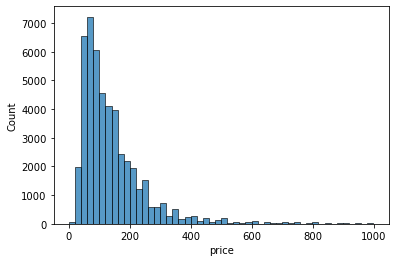

In [7]:
sns.histplot(df.price[df.price < 1000], bins = 50)

In [8]:
features= df[
    ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
]

### Question 1

In [9]:
features.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Question 2

In [10]:
features['minimum_nights'].describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [11]:
np.random.seed(42)

n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [12]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

### Question 3

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [15]:
base = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

In [16]:
# case 1 - fill missing values with 0

X_train = df_train[base].fillna(0).values
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)

<AxesSubplot:ylabel='Count'>

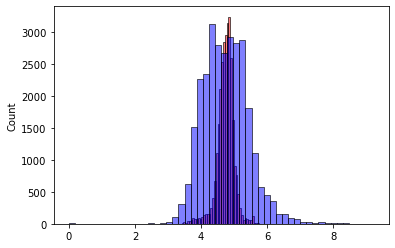

In [17]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [18]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
X_val = df_val[base].fillna(0).values
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.64

In [20]:
# case 2 - fill missing values with the mean

X_train = df_train[base].fillna(df_train['reviews_per_month'].mean()).values
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)

<AxesSubplot:ylabel='Count'>

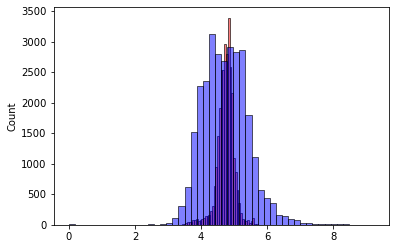

In [21]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [22]:
X_val = df_val[base].fillna(df_val['reviews_per_month'].mean()).values
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.64

### Question 4

In [23]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [24]:
X_train = df_train[base].fillna(0).values
X_val = df_val[base].fillna(0).values

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_reg_val = w_0 + X_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_reg_val),2)
    print(r, w_0, rmse_val)

0 -419.91265866086724 0.64
1e-06 -419.86271584310543 0.64
0.0001 -414.9764926433289 0.64
0.001 -375.27365274892543 0.64
0.01 -191.7838405478213 0.66
0.1 -32.562560550033176 0.68
1 -3.499216833574792 0.68
5 -0.7033623186161135 0.68
10 -0.35127676047352 0.68


### Question 5

In [29]:
def prepare_X(df, fillna_value):
    df_num = df[base]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [31]:
rmse_list = []
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for seed in seeds :
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.price.values
    y_val_orig = df_val.price.values
    y_test_orig = df_test.price.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_null_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_null_train, y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(seed, w_0, rmse_val)

0 -427.62844627426284 0.65
1 -414.70554908342683 0.65
2 -423.2541336360157 0.65
3 -421.8933158945776 0.64
4 -422.06099098594575 0.64
5 -429.178752276979 0.63
6 -427.4918955557489 0.63
7 -428.1884699089791 0.65
8 -427.6929118381776 0.65
9 -426.9826895542177 0.64


In [32]:
rmse_list

[0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.65, 0.65, 0.64]

In [34]:
round(np.std(rmse_list),3)

0.008

### Question 6

In [35]:
seed = 9

idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
    
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.price.values
y_test_orig = df_test.price.values

y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)

del df_train_val['price']
del df_test['price']

In [36]:
X_null_train_val = prepare_X(df_train_val, fillna_value=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

0.65